In [1]:
import torch
import random
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, T5ForConditionalGeneration
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy as cp
import renew_bleu
import os
from tqdm import tqdm
from collections import OrderedDict
from IPython.display import clear_output
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

/opt/conda/envs/newpy37/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda')

In [2]:
filenames = []
with open("selected_files.txt", "r") as f: # selected_files
    for l in f.readlines():
        filenames.append(l.strip())
num_of_files = len(filenames)
print("Number of C++ code files is: {}".format(num_of_files))

Number of C++ code files is: 9289


In [3]:
class CodeDataset (Dataset):
    def __init__(self, filenames):
        self.filenames = filenames
        return
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, index):
        func = ""
        func_file = "func/{}.cpp".format(self.filenames[index])
        with open(func_file, "r") as f:
            for l in f.readlines():
                func += l
        func = " ".join(func.replace('\n', " ").split())
        # print(len(func))

        label = ""
        label_file = "label/{}.text".format(self.filenames[index])
        with open(label_file, "r") as f:
            for l in f.readlines():
                label += l
        label = label.replace('//', " ").replace('/*', " ").replace('*/', " ").replace('\n', " ")
        label = " ".join(label.split())
        # print(len(label))
        
        return func, label

In [4]:
size_t = int(num_of_files * 0.8)
size_val = int(num_of_files * 0.1)
train_data = CodeDataset(filenames[:5])
train_data = CodeDataset(filenames[:size_t])
val_data = CodeDataset(filenames[size_t:size_t+size_val])
test_data = CodeDataset(filenames[size_t+size_val:])
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
print("Training sample size: {}".format(size_t))
print(train_data[1])
print("")
print("validation sample size: {}".format(size_val))
print(val_data[1])
print("")
print("Test sample size: {}".format(num_of_files-size_t-size_val))
print(test_data[1])

Training sample size: 7431
('void print(int mat[][MAX], int n, int m) { for (int i = 0; i < n; i++) { for (int j = 0; j < m; j++) { cout << mat[i][j] << " "; } cout << endl; } }', 'Function to print the resultant matrix')

validation sample size: 928
('unsigned int doublefactorial(unsigned int n) { if (n == 0 || n==1) return 1; return n*doublefactorial(n-2); }', 'function to find double factorial of given number')

Test sample size: 930
('void push(Node** head_ref, int new_data) { Node* new_node = new Node(); new_node->data = new_data; new_node->next = (*head_ref); (*head_ref) = new_node; }', 'function to add a new node at the beginning of the list')


In [5]:
tokenizer = RobertaTokenizer.from_pretrained('Salesforce/codet5-small')
model = T5ForConditionalGeneration.from_pretrained('Salesforce/codet5-small')
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32100, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32100, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Dro

In [6]:
token_length = []
for func, label in train_loader:
    for codes in func:
        token_length.append(len(tokenizer(codes)["input_ids"]))

mean_length = np.mean(token_length)
min_length = min(token_length)
max_length = max(token_length)

Mean of token length: 60.36495761001211
Min of token length: 7
Max of token length: 135


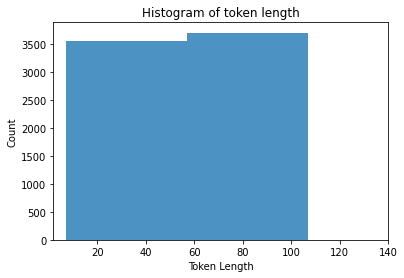

In [7]:
print("Mean of token length: {}".format(mean_length))
print("Min of token length: {}".format(min_length))
print("Max of token length: {}".format(max_length))
bins = np.arange(min_length, max_length, 50) 
plt.xlim([min_length-5, max_length+5])
plt.hist(token_length, bins=bins, alpha=0.8)
plt.title('Histogram of token length')
plt.xlabel('Token Length')
plt.ylabel('Count')
plt.show()

In [8]:
MAX_LENGTH = 110

In [9]:
# using pre-trained model to make a test
# model = T5ForConditionalGeneration.from_pretrained('Salesforce/codet5-small')
model.eval()
codes_act = []
labels_act = []
labels_pred = []


for i, (func, labels) in enumerate(test_loader):      
    for codes in func:
        codes_act.append(codes)
        inputs = tokenizer(
            codes,
            max_length=MAX_LENGTH,
            pad_to_max_length=True,
            truncation = True,
            return_tensors="pt")
        inputs.to(device)
        
        input_ids = inputs['input_ids']
        # attention_mask = inputs['attention_mask']
            
        generated_ids = model.generate(
            input_ids=input_ids, 
            # attention_mask=attention_mask, 
            max_length=128) 
            
        labels_output = tokenizer.decode(generated_ids[0], skip_special_tokens=True)            
        labels_pred.append(labels_output)

    
    for label in labels:
        labels_act.append(label)
        
    if i%10==0:
        print(i)
        

/opt/conda/envs/newpy37/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


0
10


In [10]:
def bleu4_score(labels_pred, labels_act):
    (map_act, map_pred) = renew_bleu.mapping(labels_act, labels_pred)
    bleu4 = renew_bleu.bleuFromMaps(map_act, map_pred)[0]
    return round(bleu4, 4)

In [11]:
bleu4_score = bleu4_score(labels_pred, labels_act)
print("The BLEU-4 score using the pre-trained model: {:.4f}.".format(bleu4_score))
print("")
print("Examples using pre-trained model")
for i, (code, label, prediction) in enumerate(zip(codes_act[10:20], labels_act[10:20], labels_pred[10:20])):
    print(i+1)
    print(code)
    print("")
    print(label)
    print("")
    print(prediction)
    print("")

The BLEU-4 score using the pre-trained model: 0.0054.

Examples using pre-trained model
1
unsigned int aModM(string s, unsigned int mod) { unsigned int number = 0; for (unsigned int i = 0; i < s.length(); i++) { number = (number*10 + (s[i] - '0')); number %= mod; } return number; }

utility function to calculate a%m

int

2
int nextChar(int freq[], int dist[]) { int max = INT_MIN; for (int i = 0; i < MAX_CHAR; i++) if (dist[i] <= 0 && freq[i] > 0 && (max == INT_MIN || freq[i] > freq[max])) max = i; return max; }

The function returns next eligible character with maximum frequency (Greedy!!) and zero or negative distance

int

3
void find_min(struct node* mini) { cout << "min of heap is: " << mini->key << endl; }

Function to find min node in the heap

mini

4
void printEulerTour(int root, int N) { int index = 0; eulerTree(root, index); for (int i = 0; i < (2*N-1); i++) cout << Euler[i] << " "; }

Function to print Euler Tour of tree

index++

5
int max(int a, int b) { return a > b ? a 

## Re-train model using C++ training dataset

In [9]:
def convert_to_tokens(codes, tokenizer, truncation, max_length, pad_to_max=True):
    tokens = tokenizer(codes, truncation=truncation, max_length=max_length, pad_to_max_length=pad_to_max, return_tensors="pt")
    input_ids = torch.tensor(tokens["input_ids"])
    return input_ids.to(device)

In [10]:
def train_model(model, data_loader):
    # bar = tqdm(data_loader, total=len(data_loader), desc="Training")
    model.train()
    # nb_tr_examples = 0
    nb_tr_steps, tr_loss = 0, 0
    for i, (source_ids, target_ids) in enumerate(data_loader):
        optimizer.zero_grad()
        source_ids = convert_to_tokens(source_ids, tokenizer, True, MAX_LENGTH)
        target_ids = convert_to_tokens(target_ids, tokenizer, True, MAX_LENGTH)
        # print(source_ids)
        source_mask = source_ids.ne(tokenizer.pad_token_id)
        target_mask = target_ids.ne(tokenizer.pad_token_id)
        # print(source_mask)
        
        outputs = model(input_ids=source_ids, attention_mask=source_mask,
                       labels=target_ids, decoder_attention_mask=target_mask)    
    
        loss = outputs.loss   
        loss = loss.mean()
        
        tr_loss += loss.item() 

        loss.backward()
        optimizer.step()
        nb_tr_steps += 1        
 
    train_epoch_loss = tr_loss / nb_tr_steps 
    return train_epoch_loss

In [11]:
def valid_model(model, data_loader):
    model.eval()
    
    eval_loss, batch_num = 0, 0
    # for batch in tqdm(data_loader, total=len(data_loader), desc="Validation"):
    for i, (source_ids, target_ids) in enumerate(data_loader):
      
        source_ids = convert_to_tokens(source_ids, tokenizer, True, MAX_LENGTH)
        target_ids = convert_to_tokens(target_ids, tokenizer, True, MAX_LENGTH)
        # print(source_ids)
        source_mask = source_ids.ne(tokenizer.pad_token_id)
        target_mask = target_ids.ne(tokenizer.pad_token_id)
        
        with torch.no_grad():
            outputs = model(input_ids=source_ids, attention_mask=source_mask,
                            labels=target_ids, decoder_attention_mask=target_mask)
            
            loss = outputs.loss
            loss = loss.mean()

        eval_loss += loss.item()
        batch_num += 1
         
    val_epoch_loss = eval_loss / batch_num

    return val_epoch_loss

In [12]:
def best_model(model, best_para, loss):
    if best_para["Loss"] > loss:
        best_para["Loss"] = loss
        model_state_dict = {key:value.to('cpu') for key, value in model.state_dict().items()}
        model_state_dict = OrderedDict(model_state_dict)
        best_para["Model"] = model_state_dict

In [13]:
EPOCHES = 50
LEARNING_RATE = 1e-5
model_para = {"Model": None, "Epoch": 0}
best_model_para = {"Model": None, "Loss": np.inf}
train_loss = []
val_loss = []

optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
for epoch in range(EPOCHES):
    epoch_train_loss = train_model(model, train_loader)
    train_loss.append(epoch_train_loss)
    print("Epoch [{}], training loss: {:.6f}.".format(epoch, epoch_train_loss))
    epoch_val_loss = valid_model(model, val_loader)
    val_loss.append(epoch_val_loss)
    print("Epoch [{}], validation loss: {:.6f}.".format(epoch, epoch_val_loss))
    
    epoch_state_dict = {key:value.to('cpu') for key, value in model.state_dict().items()}
    epoch_state_dict = OrderedDict(epoch_state_dict)
    para_file = "./Epoch_CodeT5_Para/" + str(epoch) + "_codeT5_para.bin"
    torch.save(epoch_state_dict, para_file)
    
    if best_model_para["Loss"] > epoch_val_loss:
        best_model_para["Loss"] = epoch_val_loss
        state_dict = {key:value.to('cpu') for key, value in model.state_dict().items()}
        state_dict = OrderedDict(state_dict)
        best_model_para["Model"] = state_dict
# save the best model        
torch.save(best_model_para["Model"], "./codeT5_model_best.bin")

/opt/conda/envs/newpy37/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/envs/newpy37/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch [0], training loss: 0.567007.
Epoch [0], validation loss: 0.349210.
Epoch [1], training loss: 0.356867.
Epoch [1], validation loss: 0.321003.
Epoch [2], training loss: 0.334879.
Epoch [2], validation loss: 0.308651.
Epoch [3], training loss: 0.323697.
Epoch [3], validation loss: 0.300306.
Epoch [4], training loss: 0.314457.
Epoch [4], validation loss: 0.293913.
Epoch [5], training loss: 0.306984.
Epoch [5], validation loss: 0.288588.
Epoch [6], training loss: 0.300318.
Epoch [6], validation loss: 0.284537.
Epoch [7], training loss: 0.294849.
Epoch [7], validation loss: 0.280661.
Epoch [8], training loss: 0.289787.
Epoch [8], validation loss: 0.277630.
Epoch [9], training loss: 0.284986.
Epoch [9], validation loss: 0.274578.
Epoch [10], training loss: 0.281672.
Epoch [10], validation loss: 0.272200.
Epoch [11], training loss: 0.275898.
Epoch [11], validation loss: 0.269643.
Epoch [12], training loss: 0.272593.
Epoch [12], validation loss: 0.267849.
Epoch [13], training loss: 0.268

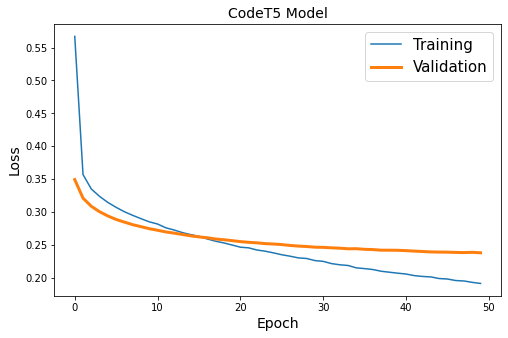

In [14]:
figure = plt.figure(figsize = [8, 5])
plt.plot(np.arange(len(train_loss[:])), train_loss[:], label='Training')
plt.plot(np.arange(len(val_loss[:])), val_loss[:], label='Validation', linewidth=3)
plt.ylabel('Loss',fontsize=14)
plt.xlabel('Epoch',fontsize=14)
plt.title("CodeT5 Model", fontsize=14)
plt.legend(fontsize=15)
plt.savefig('./CodeT5_model_loss.png')
plt.show() 

In [15]:
# the path for model parameter
arr = os.listdir('/home/jovyan/DeepLearningProject/Epoch_CodeT5_Para') 
arr.sort()
epoch_list = []
val_bleu4_score = []
for i in range(1, 51):
    epoch_list.append(str(arr[i]))
    print(arr[i])
    pytorch_model = "./Epoch_CodeT5_Para/" + arr[i]
    checkpoint = torch.load(pytorch_model, map_location='cpu')
    model.load_state_dict(checkpoint)
    model.to(device)

    model.eval()
    re_codes_act = []
    re_labels_act = []
    re_labels_pred = []
    
    for _, (func, labels) in enumerate(val_loader):      
        for codes in func:
            re_codes_act.append(codes)
            inputs = tokenizer(
                codes,
                max_length=MAX_LENGTH,
                pad_to_max_length=True,
                truncation = True,
                return_tensors="pt")
            inputs.to(device)

            input_ids = inputs['input_ids']

            generated_ids = model.generate(
                input_ids=input_ids,  
                max_length=128) 

            labels_output = tokenizer.decode(generated_ids[0], skip_special_tokens=True)            
            re_labels_pred.append(labels_output)

        for label in labels:
            re_labels_act.append(label)
     
    
    def bleu4_score(labels_pred, labels_act):
        (map_act, map_pred) = renew_bleu.mapping(labels_act, labels_pred)
        bleu4 = renew_bleu.bleuFromMaps(map_act, map_pred)[0]
        return round(bleu4, 4)

    re_bleu4_score = bleu4_score(re_labels_pred, re_labels_act)
    val_bleu4_score.append(re_bleu4_score)
    print(re_bleu4_score)


0_codeT5_para.bin
0.1932
10_codeT5_para.bin
0.2577
11_codeT5_para.bin
0.26
12_codeT5_para.bin
0.2614
13_codeT5_para.bin
0.2644
14_codeT5_para.bin
0.2657
15_codeT5_para.bin
0.2656
16_codeT5_para.bin
0.267
17_codeT5_para.bin
0.2668
18_codeT5_para.bin
0.2681
19_codeT5_para.bin
0.2714
1_codeT5_para.bin
0.2398
20_codeT5_para.bin
0.2689
21_codeT5_para.bin
0.272
22_codeT5_para.bin
0.2733
23_codeT5_para.bin
0.2756
24_codeT5_para.bin
0.2754
25_codeT5_para.bin
0.2751
26_codeT5_para.bin
0.2779
27_codeT5_para.bin
0.2768
28_codeT5_para.bin
0.2798
29_codeT5_para.bin
0.281
2_codeT5_para.bin
0.2402
30_codeT5_para.bin
0.2815
31_codeT5_para.bin
0.2821
32_codeT5_para.bin
0.2842
33_codeT5_para.bin
0.2818
34_codeT5_para.bin
0.2834
35_codeT5_para.bin
0.2839
36_codeT5_para.bin
0.2837
37_codeT5_para.bin
0.2863
38_codeT5_para.bin
0.2867
39_codeT5_para.bin
0.2835
3_codeT5_para.bin
0.2437
40_codeT5_para.bin
0.2849
41_codeT5_para.bin
0.2854
42_codeT5_para.bin
0.2858
43_codeT5_para.bin
0.2903
44_codeT5_para.bin
0.

In [55]:
new_epoch_list = epoch_list.copy()
new_bleu4_score = val_bleu4_score.copy()
num_epoch = [int(i.split('_', 1)[0]) for i in new_epoch_list]
df_val_scores = pd.DataFrame(zip(new_epoch_list, new_bleu4_score, num_epoch), columns=['epoch','bleu_score','num_epoch'])
df_val_scores.sort_values('num_epoch', ascending = True, inplace=True)
df_val_scores.head()

,epoch,bleu_score,num_epoch
0,0_codeT5_para.bin,0.1932,0
11,1_codeT5_para.bin,0.2398,1
22,2_codeT5_para.bin,0.2402,2
33,3_codeT5_para.bin,0.2437,3
44,4_codeT5_para.bin,0.2470,4


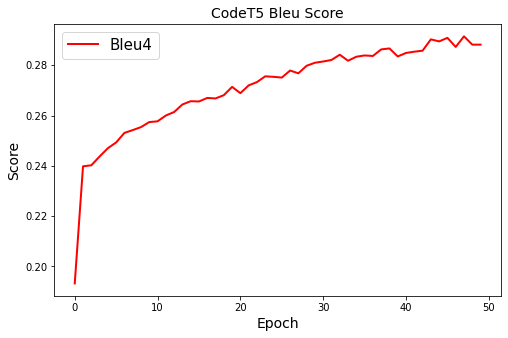

In [59]:
figure = plt.figure(figsize = [8, 5])
plt.plot(df_val_scores['num_epoch'], df_val_scores['bleu_score'], label='Bleu4', linewidth=2, color = 'red')
plt.ylabel('Score',fontsize=14)
plt.xlabel('Epoch',fontsize=14)
plt.title("CodeT5 Bleu Score", fontsize=14)
plt.legend(fontsize=15)
plt.savefig('./CodeT5_bleu4_score.png')
plt.show() 

## Model Evaluation

In [21]:
# Loading the best model 
model.load_state_dict(best_model_para["Model"])
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32100, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32100, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Dro

In [22]:
# using fine-tuning model to make a test
model.eval()
re_codes_act = []
re_labels_act = []
re_labels_pred = []

for i, (func, labels) in enumerate(test_loader):      
    for codes in func:
        re_codes_act.append(codes)
        inputs = tokenizer(
            codes,
            max_length=MAX_LENGTH,
            pad_to_max_length=True,
            truncation = True,
            return_tensors="pt")
        inputs.to(device)
        
        input_ids = inputs['input_ids']
            
        generated_ids = model.generate(
            input_ids=input_ids,  
            max_length=128) 
        
        labels_output = tokenizer.decode(generated_ids[0], skip_special_tokens=True)            
        re_labels_pred.append(labels_output)

    
    for label in labels:
        re_labels_act.append(label)
        
    if i%10==0:
        print(i)

0
10


In [23]:
def bleu4_score(labels_pred, labels_act):
    (map_act, map_pred) = renew_bleu.mapping(labels_act, labels_pred)
    bleu4 = renew_bleu.bleuFromMaps(map_act, map_pred)[0]
    return round(bleu4, 4)

In [24]:
re_bleu4_score = bleu4_score(re_labels_pred, re_labels_act)
print("The BLEU-4 score using the retrained model: {:.4f}.".format(re_bleu4_score))
print("")
print("Examples after retraining model")
for i, (code, label, prediction) in enumerate(zip(re_codes_act[10:20], re_labels_act[10:20], re_labels_pred[10:20])):
    print(i+1)
    print(code)
    print("")
    print(label)
    print("")
    print(prediction)
    print("")

The BLEU-4 score using the retrained model: 0.3017.

Examples after retraining model
1
unsigned int aModM(string s, unsigned int mod) { unsigned int number = 0; for (unsigned int i = 0; i < s.length(); i++) { number = (number*10 + (s[i] - '0')); number %= mod; } return number; }

utility function to calculate a%m

Function to calculate the mod M

2
int nextChar(int freq[], int dist[]) { int max = INT_MIN; for (int i = 0; i < MAX_CHAR; i++) if (dist[i] <= 0 && freq[i] > 0 && (max == INT_MIN || freq[i] > freq[max])) max = i; return max; }

The function returns next eligible character with maximum frequency (Greedy!!) and zero or negative distance

Function to find the next character in the array

3
void find_min(struct node* mini) { cout << "min of heap is: " << mini->key << endl; }

Function to find min node in the heap

Function to find the minimum node in the heap

4
void printEulerTour(int root, int N) { int index = 0; eulerTree(root, index); for (int i = 0; i < (2*N-1); i++) cout <<